In [3]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import geemap

In [4]:
ds = xr.open_dataset('icemotion_daily_sh_25km_20200101_20201231_v4.1.nc')

In [5]:
ds

<xarray.Dataset> Size: 453MB
Dimensions:                   (x: 321, y: 321, time: 366)
Coordinates:
  * x                         (x) float64 3kB -4.011e+06 ... 4.011e+06
  * y                         (y) float64 3kB -4.011e+06 ... 4.011e+06
  * time                      (time) object 3kB 2020-01-01 00:00:00 ... 2020-...
Data variables:
    crs                       int32 4B ...
    u                         (time, y, x) float32 151MB ...
    v                         (time, y, x) float32 151MB ...
    icemotion_error_estimate  (time, y, x) float32 151MB ...
    latitude                  (y, x) float32 412kB ...
    longitude                 (y, x) float32 412kB ...
Attributes:
    version:       4.1
    release_date:  Apr 2021
    Conventions:   CF-1.4
    dataset_doi:   10.5067/INAWUWO7QH7B

In [99]:
u = ds['u'].isel(time=0)  # componente u del vector de movimiento
v = ds['v'].isel(time=0)  # componente v del vector de movimiento
lat = ds['latitude']
lon = ds['longitude']

In [27]:
geometry = gpd.points_from_xy(lon.values.flatten(), lat.values.flatten())
gdf = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326")

In [43]:
ds['x'][0].values

array(-4010804.)

In [61]:
ds['crs']

<xarray.DataArray 'crs' ()> Size: 4B
array(-2147483647)
Attributes:
    grid_mapping_name:               lambert_azimuthal_equal_area
    longitude_of_projection_origin:  0
    false_easting:                   0
    false_northing:                  0
    long_name:                       EASEgrid_S25km
    latitude_of_projection_origin:   -90
    srid:                            urn:ogc:def:crs:EPSG::3409
    proj4text:                       +proj=laea +lat_0=-90 +lon_0=0 +x_0=0 +y...
    crs_wkt:                          PROJCS["NSIDC EASE-Grid South",GEOGCS["...

In [116]:
import pyproj

x = ds['x'].values
y = ds['y'].values

proj_from = pyproj.Proj("epsg:3409")  # EASE-Grid South
proj_to = pyproj.Proj(proj="latlong", datum="WGS84")

In [117]:
import numpy as np

lon, lat = np.meshgrid(x, y)
lon, lat = pyproj.transform(proj_from, proj_to, lon, lat)

In [118]:
lon = lon.flatten()
lat = lat.flatten()

In [119]:
u = ds['u'].isel(time=0).values
v = ds['v'].isel(time=0).values
u = u.flatten()
v = v.flatten()

In [120]:
mask = ~np.isnan(u) & ~np.isnan(v)
u = u[mask]
v = v[mask]
lon = lon[mask]
lat = lat[mask]

In [77]:
data = pd.DataFrame({
    'longitude': lon,
    'latitude': lat,
    'u': u,
    'v': v
})

# Crear GeoDataFrame
geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]
gdf = gpd.GeoDataFrame(data, geometry=geometry)

(array([164.64986351, 164.12882139, 169.3460974 , ..., -15.66210635,
        -15.1644609 , -14.66446149]),
 array([-65.98004598, -65.91802135, -66.67143316, ..., -64.74494316,
        -64.8063398 , -64.86578831]))

In [145]:
from shapely.geometry import Point

ds = xr.open_dataset('icemotion_daily_sh_25km_20200101_20201231_v4.1.nc')

# Seleccionar el primer tiempo
u = ds['u'].isel(time=259).values
v = ds['v'].isel(time=259).values
x = ds['x'].values
y = ds['y'].values

# Crear un transformador de coordenadas usando EPSG:3409
proj_from = pyproj.Proj("epsg:3409")  # EASE-Grid South
proj_to = pyproj.Proj(proj="latlong", datum="WGS84")

# Usar pyproj.Transformer para transformar las coordenadas
transformer = pyproj.Transformer.from_proj(proj_from, proj_to, always_xy=True)

# Crear listas para las geometrías y componentes de velocidad
geometries = []
us = []
vs = []

# Iterar sobre las dimensiones y convertir las coordenadas
for i in range(len(y)):
    for j in range(len(x)):
        lon, lat = transformer.transform(x[j], y[i])
        if not np.isnan(u[i, j]) and not np.isnan(v[i, j]):
            point = Point(lat, lon)
            geometries.append(point)
            us.append(u[i, j])
            vs.append(v[i, j])

# Crear un GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry': geometries, 'u': us, 'v': vs}, crs='EPSG:3409')

In [146]:
gdf

geometry     u     v
0      POINT (-62.149 -171.539) -16.9  -6.3
1       POINT (-62.363 175.276)   2.4 -11.2
2       POINT (-62.343 174.806)   2.6 -11.8
3       POINT (-62.114 171.076)   3.6 -12.4
4       POINT (-62.077 170.614)   3.5 -12.1
...                         ...   ...   ...
28708     POINT (-54.086 5.492)  -1.6   2.8
28709     POINT (-54.037 6.219)  -2.7   3.1
28710     POINT (-53.983 6.944)  -3.8   2.8
28711     POINT (-53.954 7.306)  -4.0   2.9
28712     POINT (-53.923 7.667)  -4.0   3.2

[28713 rows x 3 columns]

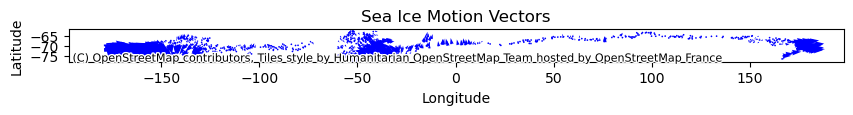

In [125]:
import contextily as ctx

fig, ax = plt.subplots(figsize=(10, 10))
plt.quiver(acotado.geometry.y, acotado.geometry.x, acotado.u, acotado.v, angles='xy', scale_units='xy', scale=1, color='blue')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sea Ice Motion Vectors')
ctx.add_basemap(ax, crs="EPSG:3409")
plt.show()

In [149]:
acotado = gdf.sample(n=2000)

In [150]:
import geemap.foliumap as geemap
import folium

Map = geemap.Map(center=[-75, 0], zoom=2)

# Añadir las flechas al mapa
for _, row in acotado.iterrows():
    folium.Marker(
        location=[row.geometry.x, row.geometry.y],
        icon=folium.DivIcon(html=f"""<div style="transform: rotate({np.arctan2(row['v'], row['u'])}rad);">
                                     <svg width="10" height="10">
                                       <line x1="0" y1="5" x2="10" y2="5" style="stroke:blue;stroke-width:2;" />
                                       <line x1="7" y1="2" x2="10" y2="5" style="stroke:blue;stroke-width:2;" />
                                       <line x1="7" y1="8" x2="10" y2="5" style="stroke:blue;stroke-width:2;" />
                                     </svg>
                                     </div>""")
    ).add_to(Map)

# Mostrar el mapa
Map

In [198]:
min_lat, max_lat = -79.32179876751927, -61.65548295000095
min_lon, max_lon = -179.7792481783923, -93.29487317839231

In [199]:
filtered_gdf = gdf[(gdf.geometry.x >= min_lat) & (gdf.geometry.x <= max_lat) &
                   (gdf.geometry.y >= min_lon) & (gdf.geometry.y <= max_lon)]

In [200]:
import pandas as pd
df = pd.DataFrame()
df['u'] = filtered_gdf['u']
df['v'] = filtered_gdf['v']

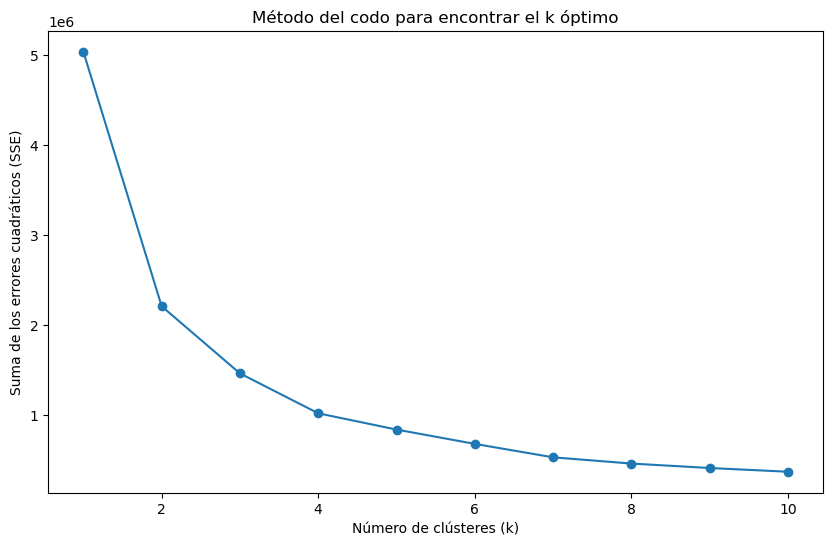

In [193]:
from sklearn.cluster import KMeans

df_clusters = df  # Sustituye con tus datos

# Definir el rango de valores de k que quieres probar
k_range = range(1, 11)

# Lista para almacenar la SSE para cada k
sse = []

# Calcular SSE para cada k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_clusters)
    sse.append(kmeans.inertia_)

# Graficar el codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos (SSE)')
plt.title('Método del codo para encontrar el k óptimo')
plt.show()

In [241]:
df_clusters = df
kmeans = KMeans(n_clusters=6, random_state=42)
df_clusters['cluster'] = kmeans.fit_predict(df)

In [242]:
colors = plt.cm.get_cmap('tab10', len(df_clusters['cluster'].unique()))
cluster_colors = {cluster: colors(i) for i, cluster in enumerate(df_clusters['cluster'].unique())}

In [243]:
df_clusters['lat'] = filtered_gdf.geometry.x
df_clusters['lon'] = filtered_gdf.geometry.y

In [244]:
acotado = df_clusters.sample(n=2000)

In [245]:
import matplotlib

Map = geemap.Map(center=[-75, 0], zoom=2)

# Añadir las flechas al mapa
for _, row in acotado.iterrows():
    color = matplotlib.colors.to_hex(cluster_colors[row['cluster']])
    folium.Marker(
        location=[row['lat'], row['lon']],
        icon=folium.DivIcon(html=f"""<div style="transform: rotate({np.arctan2(row['v'], row['u'])}rad);">
                                     <svg width="10" height="10">
                                       <line x1="0" y1="5" x2="10" y2="5" style="stroke:{color};stroke-width:2;" />
                                       <line x1="7" y1="2" x2="10" y2="5" style="stroke:{color};stroke-width:2;" />
                                       <line x1="7" y1="8" x2="10" y2="5" style="stroke:{color};stroke-width:2;" />
                                     </svg>
                                     </div>""")

    ).add_to(Map)

# Mostrar el mapa
Map

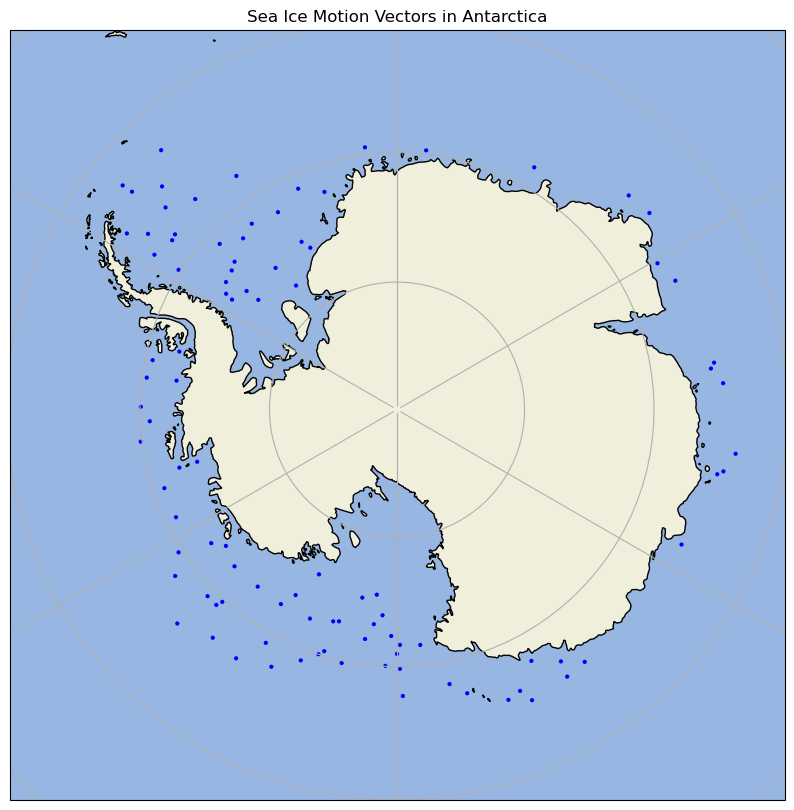

In [113]:
u = ds['u'].isel(time=0).values
v = ds['v'].isel(time=0).values
x = ds['x'].values
y = ds['y'].values

# Crear un transformador de coordenadas usando EPSG:3409
proj_from = pyproj.Proj("epsg:3409")  # EASE-Grid South
proj_to = pyproj.Proj(proj="latlong", datum="WGS84")

# Usar pyproj.Transformer para transformar las coordenadas
transformer = pyproj.Transformer.from_proj(proj_from, proj_to, always_xy=True)

# Crear listas para las geometrías y componentes de velocidad
geometries = []
us = []
vs = []
lons = []
lats = []

# Iterar sobre las dimensiones y convertir las coordenadas
for i in range(len(y)):
    for j in range(len(x)):
        lon, lat = transformer.transform(x[j], y[i])
        if not np.isnan(u[i, j]) and not np.isnan(v[i, j]):
            point = Point(lon, lat)
            geometries.append(point)
            us.append(u[i, j])
            vs.append(v[i, j])
            lons.append(lon)
            lats.append(lat)

# Crear un GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry': geometries, 'u': us, 'v': vs, 'lon': lons, 'lat': lats})

# Seleccionar una muestra aleatoria de 100 puntos
sample_gdf = gdf.sample(n=100, random_state=42)

# Extraer las coordenadas y las componentes de velocidad
x = sample_gdf['lon'].values
y = sample_gdf['lat'].values
u = sample_gdf['u'].values
v = sample_gdf['v'].values

# Crear la figura y el eje con la proyección correcta
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# Añadir características del mapa
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines()


# Añadir los vectores de movimiento del hielo marino
ax.quiver(x, y, u, v, transform=ccrs.PlateCarree(), angles='xy', scale_units='xy', scale=5, color='blue')

# Establecer el límite de la vista para centrarse en la Antártida
ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())

# Título del gráfico
plt.title('Sea Ice Motion Vectors in Antarctica')

# Mostrar el gráfico
plt.show()